================================= Author: Arman Javan Sekhavat =================================


In this notebook, a test trajectory is generated and the manipulator's 
motion is controlled by the IJC (Independent Joint Control) method to 
follow this trajectory. To assess the controller's performance, actual 
joint variables are compared with their desired values along the entire
trajectory.

In [1]:
# Standard modules
import mujoco
import numpy as np
from mujoco import viewer
import matplotlib.pyplot as plt

In [2]:
# Custom modules
import TrajectoryGeneration

In [3]:
m = mujoco.MjModel.from_xml_path("Robotic_Arm_GearDrive.xml")
d = mujoco.MjData(m)

In [4]:
#---------------------------- Generating a test trajectory which passes through the following ---------------------------
#---------------------------- points in the configuration space (via points)                  ---------------------------



q_list = np.array([[-np.pi/6, +np.pi/3, 0.0, -np.pi/2, np.pi/8, 0.03],
                    [-0.03, 0.424, 1.91, -2.94, 0.095, 0.03],
                    [0.157, 0.393, 1.44, -2.58, 0.095, 0.03],
                    [0.251, 0.314, 1.24, -2.33, 0.095, 0.06],
                    [0.534, 0.456, 1.01, -2.4, 0.251, 0.116],
                    [0.817, 0.676, 0.063, -1.73, 0.723, 0.124],
                    [1.85, 1.81, -1.26, -2.58, -0.66, 0.05]])

dt_list = np.array([3.0, 2.0, 2.0, 3.0, 1.0, 3.0]) # Duration for each path segment
a = TrajectoryGeneration.Quintic(q_list, dt_list)  # Coefficients of the quintic path generator
duration = np.sum(dt_list) # Seconds

#------- Controller gains are chosen in such a way that the
#------- closed-loop system has a critically-damped time-response
Kp = 200.0           # Position gain
Kv = 2*np.sqrt(Kp)   # Velocity gain


I = 0.001 # Motors' effective inertia
b = 0.100 # Motors' effective damping

In [5]:
mujoco.mj_resetData(m, d)

Q_d = [] # Desired joint positions
Q = [] # Actual joint positions
t = [] # Simulation time

viewer_obj = mujoco.viewer.launch_passive(m, d)

while d.time < duration:


    # Desired values
    q_d, q_dot_d, q_ddot_d = TrajectoryGeneration.QuinticGenerator(a, dt_list, d.time)

    # Actual values
    q = np.array(d.qpos[0:6])
    q_dot = np.array(d.qvel[0:6])

    # Recording values
    Q_d.append(q_d)
    Q.append(q)
    t.append(d.time)

    # Error signal
    E = q_d - q
    E_dot = q_dot_d - q_dot

    # Feedback control law
    tau_prime = q_ddot_d + Kv*E_dot + Kp*E

    d.ctrl = I*tau_prime + b*q_dot


    mujoco.mj_step(m, d)
    viewer_obj.sync()

viewer_obj.close()

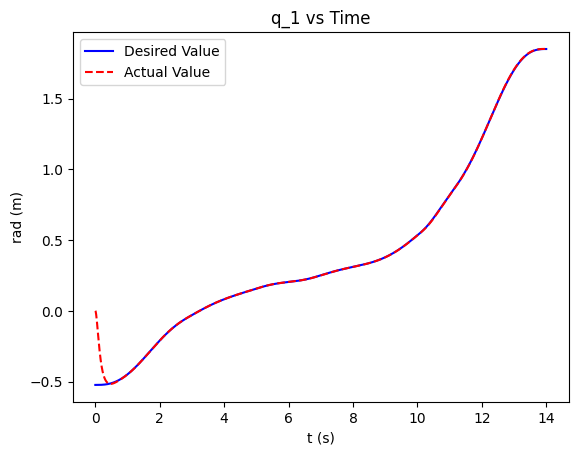

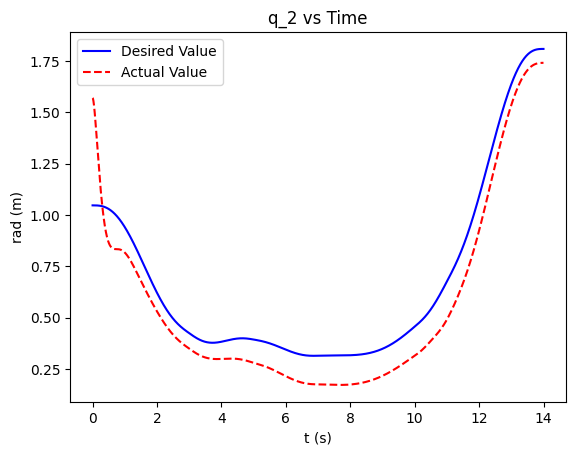

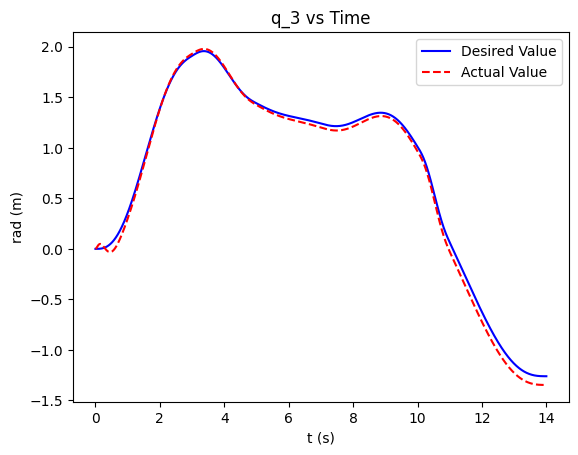

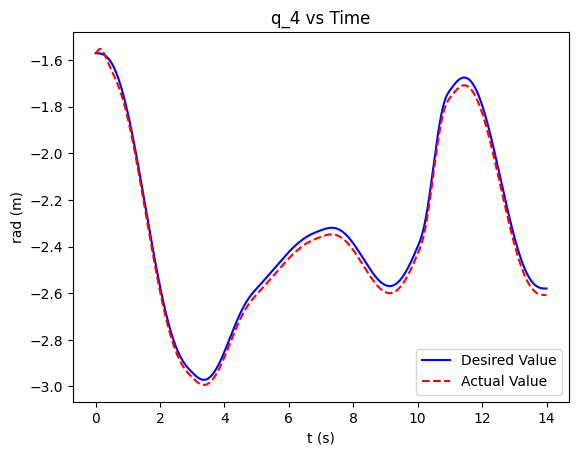

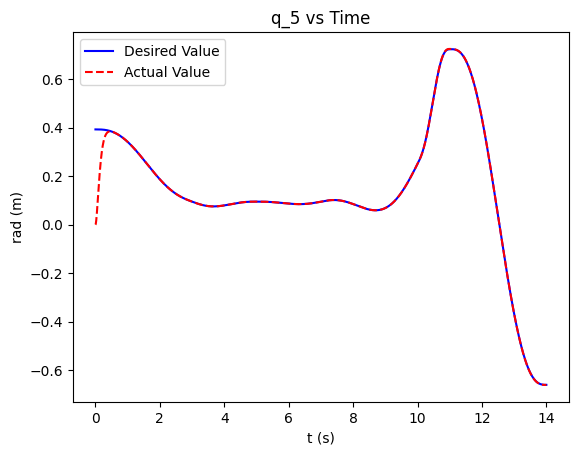

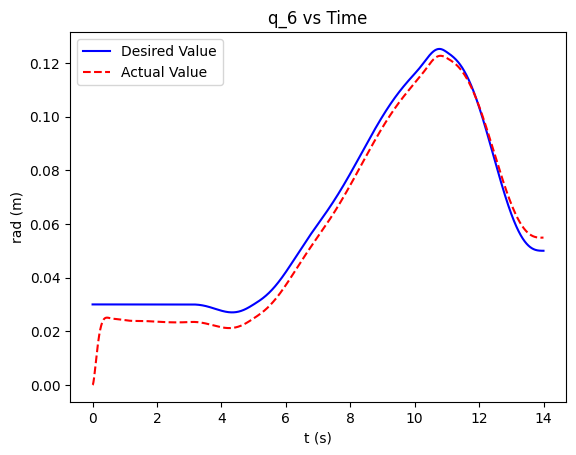

In [13]:
Q_d = np.array(Q_d)
Q = np.array(Q)
t = np.array(t)

for i in range(6):
    plt.figure()
    plt.plot(t, Q_d[:, i], label = "Desired Value", linestyle = "solid", color = "blue")
    plt.plot(t, Q[:, i], label = "Actual Value", linestyle = "dashed", color = "red")
    plt.legend()
    plt.xlabel("t (s)")
    plt.ylabel("rad (m)")
    plt.title("q_" + str(i+1) + " vs Time")
    plt.show()
